In [1]:
!pip install meteocalc

  Created wheel for meteocalc: filename=meteocalc-1.1.0-cp36-none-any.whl size=8196 sha256=52e4e258dbb85797d3667fa4c977e14403b403b48f5b25ead51668f906f68b4e
  Stored in directory: /tmp/.cache/pip/wheels/9e/34/13/83d36ecc28837e3c2a5b696542e697538e7c1025382f4ded55
Successfully built meteocalc


In [2]:
!pip install holidays

In [3]:
import gc
import os
import random

import holidays

import matplotlib.pyplot as plt

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, GroupKFold,StratifiedKFold
from sklearn.externals import joblib

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import calendar
import datetime

path_data = "/kaggle/input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"
path_dataset_region_sites = "/kaggle/input/ashrae-cities-and-timezones/"

myfavouritenumber = 666
seed = myfavouritenumber
random.seed(seed)

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like


DO_TEST = False
DO_TRAIN = True

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
print(os.listdir('/kaggle/input/'))

['ashrae-cities-and-timezones', 'lgb-models-ashrae', 'ashrae-leak-data-station', 'ashrae-energy-prediction', 'outliers-energydemand']


## Reading train data

Reading train data along with building and weather metadata.

In [5]:
#https://www.mytecbits.com/internet/python/week-number-of-month
def get_week_of_month(date_value):
    # isocalendar -- > year, week_del_año, dia_de_la_semana
    # empeizan ene le 1
    # .dt.date.values[0]
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
# 11 dummies para los meses
def set_dummies(df):
    meses_dummie = 11
    for mes_dummie in np.arange(1, meses_dummie + 1):
        df['mes' + str(mes_dummie)] = np.full(df.shape[0], 0)
        df.loc[df['timestamp'].dt.month == mes_dummie, 'mes' + str(mes_dummie)] = 1

# estacionalidades
def get_summer(df):
    summer = [6, 7, 8, 9]
    df['is_summer'] = np.zeros(df.shape[0], dtype=int)
    df.loc[df.timestamp.dt.month.isin(summer), 'is_summer'] = 1
def get_winter(df):
    winter = [1, 2, 11, 12]
    df['is_winter'] = np.zeros(df.shape[0], dtype=int)
    df.loc[df.timestamp.dt.month.isin(winter), 'is_winter'] = 1

# centrarse en fines de semana
def is_weekend(df):
    weekend = [5,6] # empieza en 0
    df['is_weekend'] = np.zeros(df.shape[0], dtype=int)
    df.loc[df.timestamp.dt.dayofweek.isin(weekend), 'is_weekend'] = 1

#RMSLE
def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error( np.clip(y_true, 0, np.max(y_true)),
                                                   np.clip(y_pred, 0,np.max(y_pred) )))
# importancia de las carac
def plot_fi(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=model.feature_name(),
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()
    
# importancia para CATBOOST
def plot_fi_cat(model):
    importance_df = pd.DataFrame(model.get_feature_importance(),
                                 index=model.feature_names_,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()
# TEMPERATURA caracs
def humidity(df):
    df['humidity'] = 100 - 5 * (df['air_temperature'] - df['dew_temperature'])

# feels like
def feels_like_df(df):
    #lambda row: my_test(row['a'], row['c'])
    df['feels'] = df.apply(lambda row: feels_like(temperature=row['air_temperature'],humidity=row['humidity'],
                                                      wind_speed=row['wind_speed']), axis=1)
    df['feels'] = df['feels'].astype(np.float16)
    df['feels'] = np.round(df['feels'], 2)
    
#https://www.kaggle.com/caesarlupum/ashrae-ligthgbm-simple-fe/comments
def beaufort_scale(df):
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

    for item in beaufort:
        df.loc[(df['wind_speed']>=item[1])
               & (df['wind_speed']<item[2]),
               'beaufort_scale'] = item[0]
        
    df['beaufort_scale'] = df['beaufort_scale'].fillna(-999)
    df['beaufort_scale'] = df['beaufort_scale'].astype(np.int16) 
        
# Convert wind direction into categorical feature. We can split 360 degrees into 16-wind compass rose. 
# See this: https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose
def degToCompass(num):
    val=int((num/22.5))
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

def wind_direction_to_categorical(df):
    df['wind_direction'] = df['wind_direction'].apply(degToCompass)
    

**VACACIONES**

In [6]:
# VACACIONES
def get_holidays(site):
    
    df_sites_regions = pd.read_csv(path_dataset_region_sites + 'site_ids.csv')
    #print(df_sites_regions[['site_id', 'location', 'country']])
    
    not_USA_holidays = [1, 5, 7, 11, 12]
    
    # es americano
    if site not in not_USA_holidays:
        # limpiamos
        state = df_sites_regions[df_sites_regions.site_id == site]
        state = state.location.values[0]
        state = state.replace(" ", "")
        state = state.split(',')[1]

        list_holidays = holidays.UnitedStates(state=state)
        
    # UK
    elif site in [1, 5]:
        list_holidays = holidays.UnitedKingdom()
        
    # CANADA
    elif site in [7, 11]:
        if site == 7:
            list_holidays = holidays.Canada(prov='QC')
        else:
            list_holidays = holidays.Canada(prov='ON')
    
    # IRLANDA
    else:
        list_holidays = holidays.Ireland()
        
    return list_holidays['2016-01-01':'2017-12-31'] +\
    list_holidays['2018-01-01':'2018-12-31'] #esto por el bug que tiene la libreria

In [7]:
#https://www.kaggle.com/purist1024/ashrae-simple-data-cleanup-lb-1-08-no-leaks
# 3000, 7500
def make_is_bad_zero(Xy_subset, min_interval=48,
                     summer_start=datetime.datetime(2016,4,1),
                     summer_end=datetime.datetime(2016,10,1)):
    """Helper routine for 'find_bad_zeros'.
    
    This operates upon a single dataframe produced by 'groupby'. We expect an 
    additional column 'meter_id' which is a duplicate of 'meter' because groupby 
    eliminates the original one."""
    meter = Xy_subset.meter_id.iloc[0]
    is_zero = Xy_subset.meter_reading == 0
    if meter == 0:
        # Electrical meters should never be zero. Keep all zero-readings in this table so that
        # they will all be dropped in the train set.
        return is_zero

    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    if meter in [2, 3]:
        # It's normal for steam and hotwater to be turned off during the summer
        # ++ .timestamp()
        keep = set(ids[(Xy_subset.timestamp < summer_start) |
                       (Xy_subset.timestamp > summer_end)].unique())
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval)
    elif meter == 1:
        time_ids = ids.to_frame().join(Xy_subset.timestamp).set_index("timestamp").ids
        is_bad = ids.map(ids.value_counts()) >= min_interval

        # Cold water may be turned off during the winter
        jan_id = time_ids.get(0, False)
        dec_id = time_ids.get(8283, False)
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
    else:
        raise Exception(f"Unexpected meter type: {meter}")

    result = is_zero.copy()
    result.update(is_bad)
    return result

def find_bad_zeros(X, y):
    """Returns an Index object containing only the rows which should be deleted."""
    Xy = X.assign(meter_reading=y, meter_id=X.meter)
    is_bad_zero = Xy.groupby(["building_id", "meter"]).apply(make_is_bad_zero)
    return is_bad_zero[is_bad_zero].index.droplevel([0, 1])

def find_bad_sitezero(X):
    """Returns indices of bad rows from the early days of Site 0 (UCF)."""
    veinte_del_cinco = datetime.datetime(2016,5,20)
    return X[(X.timestamp < veinte_del_cinco) & (X.site_id == 0) & (X.meter == 0)].index

def find_bad_building1099(X, y):
    """Returns indices of bad rows (with absurdly high readings) from building 1099."""
    return X[(X.building_id == 1099) & (X.meter == 2) & (y > 3e4)].index

def find_bad_rows(X, y):
    return find_bad_zeros(X, y).union(find_bad_sitezero(X)).union(find_bad_building1099(X, y))

In [8]:
#https://www.kaggle.com/rohanrao/ashrae-divide-and-conquer
def create_lag_features(df, window):
    """
    Creating lag-based features looking back in time.
    """
    
    feature_cols = ["air_temperature", "humidity"]
    df_site = df.groupby("site_id")
    
    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)
    
    df_mean = df_rolled.mean().reset_index().astype(np.float16)
    df_median = df_rolled.median().reset_index().astype(np.float16)
    df_min = df_rolled.min().reset_index().astype(np.float16)
    df_max = df_rolled.max().reset_index().astype(np.float16)
    df_std = df_rolled.std().reset_index().astype(np.float16)
    df_skew = df_rolled.skew().reset_index().astype(np.float16)
    
    for feature in feature_cols:
        df[f"{feature}_mean_lag{window}"] = df_mean[feature]
        #df[f"{feature}_median_lag{window}"] = df_median[feature]
        df[f"{feature}_min_lag{window}"] = df_min[feature]
        df[f"{feature}_max_lag{window}"] = df_max[feature]
        #df[f"{feature}_std_lag{window}"] = df_std[feature]
        #df[f"{feature}_skew_lag{window}"] = df_skew[feature]
        
    return df

Para ajustar la temperatura
# # ---

In [9]:
%%time
weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}

weather_train = pd.read_csv(path_weather_train,dtype=weather_dtypes,
    parse_dates=['timestamp'])
weather_test = pd.read_csv(path_weather_test,dtype=weather_dtypes,
    parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
#del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather, weather_train, weather_test

CPU times: user 768 ms, sys: 100 ms, total: 868 ms
Wall time: 1.18 s


In [10]:
%%time
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
# La hora pico de temperatura suele estar sobre las 8-9 de la tarde en el dataset (deberia estar), por lo que se le resta 14
#(a las dos suele ser la hora pico), dando un array de offsets/desplazamientos --> cuantas veces hay que moverse
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

del df_2d
gc.collect()

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

CPU times: user 620 ms, sys: 16 ms, total: 636 ms
Wall time: 585 ms


El resto
 ---

In [11]:
CATEGORY_COLS = [  "building_id","site_id", "meter", "primary_use",
                'is_weekend',"hour","weekday" ,"year"] #, 'weekofmonth',
# ,'is_holiday'"hour", "weekday", , 'year_built'
#,'beaufort_scale', 'wind_direction''is_summer',

FEATURE_COLS = ['square_feet', 'floor_count'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature',  'wind_speed']  #+windspeed --'precip_depth_1_hr',

USAR_LEAKED_DATA = False

In [12]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)     
    
        # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

**Outliers**

In [14]:
# outlierrs
def detect_outlier(data_1):
    
    # threshold=8
    return data_1[np.abs((data_1- np.mean(data_1))/np.std(data_1)) > 8].values

def remove_outliers(df):
    
    outliers_tuples = []
    for building in df.building_id.unique():
        print(building)
        for meter in df[df['building_id'] == building].meter.unique():
            outliers = detect_outlier(df[(df['building_id'] == building) & (df['meter'] == meter)].meter_reading)
            if len(outliers) == 1:
                outliers_tuples.append([building, meter, outliers[0]])
                
    return outliers_tuples
            
        

In [15]:
candidatos_out = [
    [60,1], [101,0],[103,1],[112,3], [138,3], [144,3], [745,1], [755,1], [762,2], [765,1], [769,1],[769,2], [770,1], [771,1],
    [776,1], [777,1],[787,1], [1000,0], [1000,3],[1003,1], [1017,1], [1017,3], [1018,1], [1276, 1], [1426, 2]
]
#candidatos_out = []

In [16]:
%%time
if DO_TRAIN == True:
    df_train = pd.read_csv(path_train)#.sample(10000)
    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")') #++
    df_train = df_train.query('not (building_id == 1099 & meter == 2 & meter_reading > 3e4)') #outlier

    # csv outliers
    outliers = pd.read_csv('/kaggle/input/outliers-energydemand/outliers.csv')
    count = 0
    for index, fila in outliers.iterrows():
        if [fila.building_id, fila.meter] in candidatos_out:
            print([fila.building_id, fila.meter])
            print(count)
            count += 1
            df_train = df_train.query('not (building_id == ' + str(int(fila.building_id)) +\
                                      ' & meter == ' + str(int(fila.meter)) +\
                                      ' & meter_reading >= ' + str(fila.meter_reading) + ')')
    del outliers
    gc.collect()

    #get_summer(df_train)
    # fin de semana
    is_weekend(df_train) #++

# BUILDING META
building = pd.read_csv(path_building)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

[112.0, 3.0]
0
[138.0, 3.0]
1
[144.0, 3.0]
2
[745.0, 1.0]
3
[755.0, 1.0]
4
[762.0, 2.0]
5
[765.0, 1.0]
6
[769.0, 2.0]
7
[769.0, 1.0]
8
[770.0, 1.0]
9
[771.0, 1.0]
10
[776.0, 1.0]
11
[777.0, 1.0]
12
[787.0, 1.0]
13
[1000.0, 0.0]
14
[1000.0, 3.0]
15
[1003.0, 1.0]
16
[1017.0, 1.0]
17
[1017.0, 3.0]
18
[1018.0, 1.0]
19
[1276.0, 1.0]
20
[1426.0, 2.0]
21
[60.0, 1.0]
22
[103.0, 1.0]
23
[101.0, 0.0]
24
CPU times: user 37.7 s, sys: 20.4 s, total: 58.1 s
Wall time: 51.5 s


In [17]:
%%time
if DO_TRAIN == True:
    weather_train = pd.read_csv(path_weather_train)
    #rellenar nans 
    weather_train = fill_weather_dataset(weather_train)
    # a datetime
    weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
    # ajustar horas de temperaturas
    weather_train = timestamp_align(weather_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


CPU times: user 19.7 s, sys: 236 ms, total: 19.9 s
Wall time: 19.3 s


In [18]:
%%time
if DO_TRAIN == True:
    print('Humedad')
    humidity(weather_train)
    #print('Feels like')
    #feels_like_df(weather_train)

Humedad
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.13 ms


In [19]:
%%time
#if DO_TRAIN == True:
    #weather_train = create_lag_features(weather_train, 24)
    #weather_train = create_lag_features(weather_train, 48)
    # TODO probar +48

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [20]:
%%time
if DO_TRAIN == True:
    print('Calculando semana del mes...')
    #df_train['weekofmonth'] = df_train['timestamp'].apply(get_week_of_month) #++

    # para los meses negativos 
    # 53 porque es bisiesto
    #df_train.loc[df_train.weekofmonth < 0, 'weekofmonth'] = 53 + df_train.loc[df_train.weekofmonth < 0, 'weekofmonth'] #++
    print(df_train.shape)

Calculando semana del mes...
(19866510, 5)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 138 µs


In [21]:
if DO_TRAIN == True:
    df_train = reduce_mem_usage(df_train)
    building = reduce_mem_usage(building)
    weather_train = reduce_mem_usage(weather_train)

Memory usage of dataframe is 909.42 MB
Memory usage after optimization is: 454.71 MB
Decreased by 50.0%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 66.5%
Memory usage of dataframe is 11.80 MB
Memory usage after optimization is: 5.63 MB
Decreased by 52.3%


## Preparing data
There are two files with features that need to be merged with the data. One is building metadata that has information on the buildings and the other is weather data that has information on the weather.   

Note that the only features created are hour, weekday and is_holiday!

In [22]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.sort_values("timestamp")
    X.reset_index(drop=True)
    
    gc.collect()
    
    #X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    X['year'] = np.uint8(X['timestamp'].dt.year) #++
    #X['week'] = np.uint8(X['timestamp'].dt.week) #++
    #X['day'] = X['timestamp'].dt.day #++
    X["hour"] = np.uint8(X.timestamp.dt.hour) #--
    X["weekday"] = np.uint8(X.timestamp.dt.weekday) #--
    #X['year_built'] = np.uint8(X['year_built']-1900) #++
    #X['hourofyear']  = np.uint16(np.uint16(X.timestamp.dt.dayofyear) * (np.uint8(X.timestamp.dt.hour) + 1))
    
    #X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int) #--
    '''
    X["is_holiday"] = np.zeros(X.shape[0], dtype=int)
    for site in range(0, 16):
        print('Llenando vacaciones de sitio ', site)
        X.loc[X.site_id == site, "is_holiday"] = (X.timestamp.dt.date.isin(get_holidays(site))).astype(int)
        gc.collect()

    # https://www.kaggle.com/ragnar123/another-1-08-lb-no-leak
    X['group'] = X['timestamp'].dt.month
    X['group'].replace((1, 2, 3, 4), 1, inplace = True)
    X['group'].replace((5, 6, 7, 8), 2, inplace = True)
    X['group'].replace((9, 10, 11, 12), 3, inplace = True)
    '''
    # nuevas
    #beaufort_scale(X)
    #wind_direction_to_categorical(X)
    
    drop_features = ["sea_level_pressure", 'floor_count', 'offset',
                    'precip_depth_1_hr','year_built', "wind_direction",
                     'dew_temperature']  #'timestamp', 'feels', 'beaufort_scale',
    
    if 'floor_count' not in drop_features:
        # para tratar el enorme numero de floor_count a Nan
        X['floor_count'] = X['floor_count'].fillna(1)

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        X.drop(['timestamp'], axis=1, inplace=True) #++
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        '''
        # bad rows
        print('shape', X.shape)
        bad_rows = find_bad_rows(X, y)
        X = X.drop(bad_rows)
        print('bad rows', bad_rows.shape)
        print('shape', X.shape)
        y = y.drop(bad_rows)
        '''
        X.drop(['timestamp'], axis=1, inplace=True)

        return X, y
   
#----------------------------------------------------------------------------------------------------------------------------------------
def get_leak_validation():
    
    leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')#.sample(10000)
    leak_df.fillna(0, inplace=True)
    leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
    leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
    leak_df = leak_df[leak_df.building_id!=245]
    print(leak_df.shape)
    
    # lo que se necesita para estar ok
    #print('Calculando semana del mes...')
    leak_df['timestamp'] = pd.to_datetime(leak_df['timestamp'])
    #leak_df['weekofmonth'] = leak_df['timestamp'].apply(get_week_of_month)
    # para los meses negativos
    #leak_df.loc[leak_df.weekofmonth < 0, 'weekofmonth'] = 52 + leak_df.loc[leak_df.weekofmonth < 0, 'weekofmonth'] 
    
    is_weekend(leak_df)

    print('temperatura leak')
    weather_test = pd.read_csv(path_weather_test)
    weather_test = fill_weather_dataset(weather_test)
    weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])
    weather_test = timestamp_align(weather_test)
    humidity(weather_test)
    #feels_like_df(weather_test)

    leak_df = reduce_mem_usage(leak_df)
    weather_test = reduce_mem_usage(weather_test)
    gc.collect()
    
    print('Juntando leak')
    X_train_leak, y_train_leak = prepare_data(leak_df, building, weather_test)
    del leak_df, weather_test
    gc.collect()
    
    return X_train_leak, y_train_leak

In [23]:
%%time
if DO_TRAIN == True:
    X_train, y_train = prepare_data(df_train, building, weather_train)
    #X_train = X_train.drop(columns=["index"])
    del df_train, weather_train
    gc.collect()

CPU times: user 17.3 s, sys: 10.5 s, total: 27.8 s
Wall time: 25 s


AQUI LOS ALGORITMOS 
---

In [24]:
metric = 'rmse' 
tecnica_split = 'normal'
params = {
    "objective": "regression",
    "boosting": "gbdt", #gbdt
    "num_leaves": 600, #600 numero hojas por arbol
    "learning_rate": 0.005, #0.005
    "feature_fraction": 0.85,
    #'bagging_fraction': 0.85,
    #'max_bin': 512,
    #'reg_alpha': 5,#lambda1
    "reg_lambda": 2, #lambda2
    #'max_depth': 15, #++
    #'min_data_in_leaf': 5, #++
    #'min_child_weight': 1,
    #'min_split_gain': 0.001,
    "metric": metric
}
'''
params = {"objective": "regression",
                  "num_leaves": 600,
                  "learning_rate": 0.005,
                  "bagging_freq": 5,
                  "bagging_fraction": 0.51,
                  "feature_fraction": 0.81,
                  "metric": "rmse"
                  }
'''

'\nparams = {"objective": "regression",\n                  "num_leaves": 600,\n                  "learning_rate": 0.005,\n                  "bagging_freq": 5,\n                  "bagging_fraction": 0.51,\n                  "feature_fraction": 0.81,\n                  "metric": "rmse"\n                  }\n'

In [25]:
#---------------------------------------------------------------------------------------------
def LIGHTGBM_model(metric, params, train_set, valid_sets):
    
    print('Lightgbm model')
    model_lgbm = lgb.train(params,
                           train_set=train_set, num_boost_round=6000, valid_sets=valid_sets,
                           verbose_eval=200, early_stopping_rounds=500)
    print('best_score', model_lgbm.best_score)
    log = {'train/mae': model_lgbm.best_score['training'][metric],
           'valid/mae': model_lgbm.best_score['valid_1'][metric]}
    
    return model_lgbm, log

#---------------------------------------------------------------------------------------------  

In [26]:

folds =3
seed = 666
shuffle = False
group_folds_label = ['building_id'] # ,building_id, weekofmonth
DO_FOLDS = True
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
skf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=seed)
LIBRERIA = 'lgb' #cat, lgb, xgb

In [27]:
#------------------------------------------------------------------------------------------------------------
def validate_with_leak(X_train, y_train):
    
    leak_valid_x, leak_valid_y = get_leak_validation()
    y_pred_valid = np.zeros(leak_valid_x.shape[0])
    
    print('Preparando datasets')
    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=CATEGORY_COLS)
    d_valid = lgb.Dataset(leak_valid_x, label=leak_valid_y, categorical_feature=CATEGORY_COLS)
    watchlist = [d_train, d_valid]

    model, log = LIGHTGBM_model(metric, params, d_train, watchlist)

    print('Prediccion...')
    y_pred_valid = model.predict(leak_valid_x, num_iteration=model.best_iteration)

    plot_fi(model)
    # save model
    joblib.dump(model, LIBRERIA + '_' + 'leak' + '.pkl')
    
    print('RMSE:', np.sqrt(mean_squared_error( np.clip(leak_valid_y, 0, np.max(leak_valid_y)),
                                              np.clip(y_pred_valid, 0,np.max(y_pred_valid) ))))
    return [model]
#-------------------------------------------------------------------------------------------------------------
def leak_kfolds(X_train, y_train, kf):
    
    n_folds = 0
    leak_valid_x, leak_valid_y = get_leak_validation()
    y_valid_pred_total = np.zeros(leak_valid_x.shape[0])
    
    modelos = []
    for train_idx, valid_idx in kf.split(X_train, y_train, groups=X_train[group_folds_label]): #kf.split(...)
        print('Folds --> ', n_folds)
        n_folds += 1
        X_train_fold, y_train_fold = X_train.iloc[train_idx,:], y_train[train_idx]
        print('train', len(train_idx), 'valid', len(leak_valid_y))
        #--------------------------------------------------------------------------------------------
        d_train = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=CATEGORY_COLS)
        d_valid = lgb.Dataset(leak_valid_x, label=leak_valid_y, categorical_feature=CATEGORY_COLS)
        watchlist = [d_train, d_valid]

        model, log = LIGHTGBM_model(metric, params, d_train, watchlist)

        y_pred_valid = np.zeros(leak_valid_x.shape[0])
        y_pred_valid = model.predict(leak_valid_x, num_iteration=model.best_iteration)
        print('RMSE SUB MODELO: ', np.sqrt(mean_squared_error( np.clip(leak_valid_y, 0, np.max(leak_valid_y)),
                                              np.clip(y_pred_valid, 0,np.max(y_pred_valid) ))))

        plot_fi(model)
        #--------------------------------------------------------------------------------------------
        # save model
        joblib.dump(model, LIBRERIA + '_' + 'leak_' +  str(n_folds) + '.pkl')
        
        y_valid_pred_total += y_pred_valid
        
        modelos.append(model)
        gc.collect()
     
    #++++++++++++++
    y_valid_pred_total = y_valid_pred_total/len(modelos)
    print('RMSE:', np.sqrt(mean_squared_error( np.clip(leak_valid_y, 0, np.max(leak_valid_y)),
                                              np.clip(y_valid_pred_total, 0,np.max(y_valid_pred_total) ))))
    
    return modelos
    
#-------------------------------------------------------------------------------------------------------------
def kfolds(X_train, y_train, kf, libreria='cat'):

    n_folds = 0
    y_valid_pred_total = np.zeros(X_train.shape[0])
    modelos = []
    for train_idx, valid_idx in kf.split(X_train, y_train, groups=X_train[group_folds_label]): #kf.split(...)
        print('Folds --> ', n_folds)
        n_folds += 1
        X_train_fold, y_train_fold = X_train.iloc[train_idx,:], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train.iloc[valid_idx,:], y_train[valid_idx]
        print('train', len(train_idx), 'valid', len(valid_idx))
        #--------------------------------------------------------------------------------------------
        d_train = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=CATEGORY_COLS)
        d_valid = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=CATEGORY_COLS)
        watchlist = [d_train, d_valid]

        model, log = LIGHTGBM_model(metric, params, d_train, watchlist)

        y_pred_valid = model.predict(X_valid_fold, num_iteration=model.best_iteration)

        plot_fi(model)
        #--------------------------------------------------------------------------------------------
        # save model
        joblib.dump(model, LIBRERIA + '_' + str(n_folds) + '.pkl')
        #model.save_model(LIBRERIA + '_' + str(n_folds) + '.txt')
        
        y_valid_pred_total[valid_idx] = y_pred_valid
        
        modelos.append(model)
        gc.collect()
     
    #++++++++++++++
    print('RMSE:', np.sqrt(mean_squared_error( np.clip(y_train, 0, np.max(y_train)),
                                              np.clip(y_valid_pred_total, 0,np.max(y_valid_pred_total) ))))
    return modelos
#-------------------------------------------------------------------------------------------------------------
#TODO
def Stratify_kfolds(X_train, y_train, kf):

    n_folds = 0
    y_valid_pred_total = np.zeros(X_train.shape[0])
    modelos = []
    for train_idx, valid_idx in tqdm(kf.split(X_train, X_train['group']), total = 3):
        print('Folds --> ', n_folds)
        n_folds += 1
        X_train_fold, y_train_fold = X_train.iloc[train_idx,:], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train.iloc[valid_idx,:], y_train[valid_idx]
        print('train', len(train_idx), 'valid', len(valid_idx))
        #--------------------------------------------------------------------------------------------
        d_train = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=CATEGORY_COLS)
        d_valid = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=CATEGORY_COLS)
        watchlist = [d_train, d_valid]

        model, log = LIGHTGBM_model(metric, params, d_train, watchlist)

        y_pred_valid = model.predict(X_valid_fold, num_iteration=model.best_iteration)

        plot_fi(model)
        #--------------------------------------------------------------------------------------------
        # save model
        joblib.dump(model, LIBRERIA + '_' + str(n_folds) + '.pkl')
        #model.save_model(LIBRERIA + '_' + str(n_folds) + '.txt')
        
        y_valid_pred_total[valid_idx] = y_pred_valid
        
        modelos.append(model)
        gc.collect()
     
    #++++++++++++++
    print('RMSE:', np.sqrt(mean_squared_error( np.clip(y_train, 0, np.max(y_train)),
                                              np.clip(y_valid_pred_total, 0,np.max(y_valid_pred_total) ))))
    return modelos


Aqui entrenamos
----

In [28]:
if DO_TRAIN == True:
    X_train.head()

Folds -->  0
train 13244340 valid 6622170
Lightgbm model


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 1.25224	valid_1's rmse: 1.36931
[400]	training's rmse: 0.999468	valid_1's rmse: 1.17745
[600]	training's rmse: 0.910382	valid_1's rmse: 1.13241
[800]	training's rmse: 0.862201	valid_1's rmse: 1.11935
[1000]	training's rmse: 0.830308	valid_1's rmse: 1.11546
[1200]	training's rmse: 0.807685	valid_1's rmse: 1.11542
[1400]	training's rmse: 0.791478	valid_1's rmse: 1.11583
Early stopping, best iteration is:
[1081]	training's rmse: 0.820159	valid_1's rmse: 1.1151
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 0.820159388638609)]), 'valid_1': OrderedDict([('rmse', 1.1151045483197137)])})
Folds -->  1
train 13244340 valid 6622170
Lightgbm model
Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 1.24787	valid_1's rmse: 1.34059
[400]	training's rmse: 0.994204	valid_1's rmse: 1.13162
[600]	training's rmse: 0.914843	valid_1's rmse: 1.0

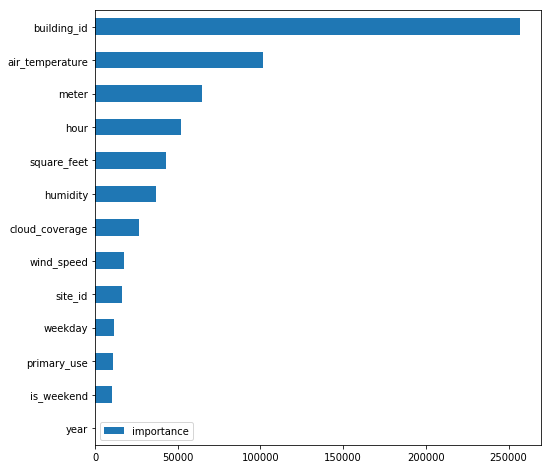

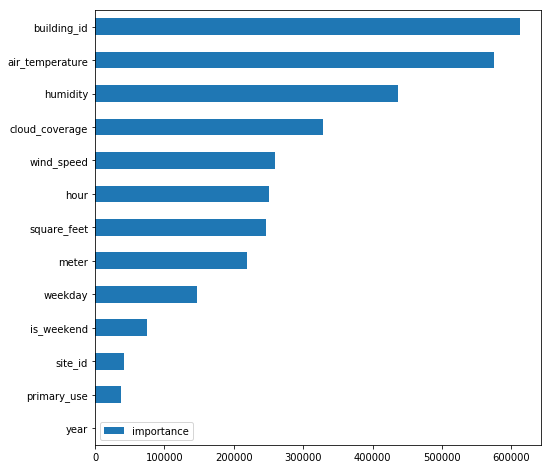

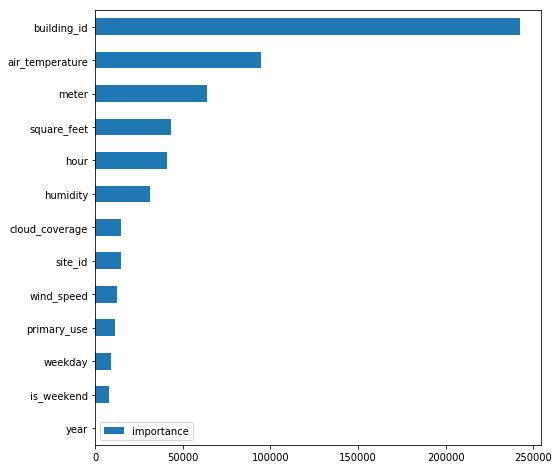

In [29]:
%%time
if DO_TRAIN == True:
    modelos = kfolds(X_train, y_train, kf)
    #modelos = Stratify_kfolds(X_train, y_train, skf)
    #modelos = validate_with_leak(X_train, y_train)
    #modelos =  leak_kfolds(X_train, y_train, kf)

In [30]:
if DO_TRAIN == True:
    del X_train, y_train
    gc.collect()

## Preparing test data
# # Preparing test data with same features as train data.

In [31]:
%%time
if DO_TEST == True:
    df_test = pd.read_csv(path_test)
    df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
    #print('Calculando semana del mes...')
    #df_test['weekofmonth'] = df_test['timestamp'].apply(get_week_of_month) #++
    #df_test.loc[df_test.weekofmonth < 0, 'weekofmonth'] = 52 + df_test.loc[df_test.weekofmonth < 0, 'weekofmonth']

    gc.collect()

    #get_summer(df_test)
    #get_winter(df_test)
    is_weekend(df_test) #++

    print('Temperatura test')
    weather_test = pd.read_csv(path_weather_test)
    #rellenar nans 
    weather_test = fill_weather_dataset(weather_test)
    # a datetime
    weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])
    # ajustar horas de temperaturas
    weather_test = timestamp_align(weather_test)
    
    # temp features
    humidity(weather_test)
    #feels_like_df(weather_test)
    
    weather_test = create_lag_features(weather_test, 24)
    # TODO probar +48

    df_test = reduce_mem_usage(df_test)
    weather_test = reduce_mem_usage(weather_test)
    gc.collect()

    print('Preparando datos')
    X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

    print("Test memory size: ",  X_test.memory_usage().sum() / 1024 / 1024)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


In [32]:
if DO_TEST == True:
    del  df_test, building, weather_test
    gc.collect()

In [33]:
if DO_TEST == True:
    print(X_test.isna().sum())

## Scoring test data
# # Averaging predictions from the two half train data models.

In [34]:
#---------------------------------------------------------------------------------------------------------------
def pred_kfolds(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    print(models)
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test
            
        del model
        gc.collect()
    

    y_test_pred_total /= 3 # prediccion con media de modelos
    return y_test_pred_total
#---------------------------------------------------------------------------------------------------------------
# predecir todo el vector
def pred_todo(X_test, models):
    
    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        y_test_pred_total += model.predict(X_test, num_iteration=model.best_iteration)
        
        del model
        gc.collect()
        
    y_test_pred_total /= 3 # prediccion con media de modelos
    return y_test_pred_total
#---------------------------------------------------------------------------------------------------------------
def pred_kfolds_from_dict(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    print(modelos)
    for key, model in models.items():
        #if key == 'lgb_2':
        print('predicting '+ key + ' model')
        print(model)
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

        del model
        gc.collect()
    

    y_test_pred_total /= 3 # prediccion con media de modelos
    return y_test_pred_total

In [35]:
%%time
from sklearn.externals import joblib

PATH_dataset_modelos = '/kaggle/input/lgb-models-ashrae/modelos_v251/' #_v251

if DO_TEST == True and DO_TRAIN == False:
    modelos = {}
    for file in os.listdir(PATH_dataset_modelos):
        if file.endswith('.pkl'):
            print(file)
            lgb_pickle = joblib.load(PATH_dataset_modelos + file)                                                                                                                                                                                                                                                                           
            # load model
            #lgb_pickle = lgb.Booster(model_file='/kaggle/input/lgb-models-ashrae/' + file)
            #modelos.append(lgb_pickle)
            key = file.split('.')[0]
            print(key)
            modelos[key] = lgb_pickle
            
    del lgb_pickle
    gc.collect()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.5 µs


In [36]:
%%time
if DO_TEST == True and DO_TRAIN == False:
    pred = np.expm1(pred_kfolds_from_dict(X_test, modelos)) 

if DO_TEST == True and DO_TRAIN == True:
    pred = np.expm1(pred_kfolds(X_test, modelos)) 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


## Submission
# # Preparing final file for submission.

In [37]:
if DO_TEST == True:
    submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
    submission['meter_reading'] = submission['meter_reading'].clip(lower=0)
    print(submission.head(15))


In [38]:
if DO_TEST == True:
    submission.to_csv("submission_lgb2_v251_2.csv", index=False)

In [39]:
import pandas as pd
site_ids = pd.read_csv("../input/ashrae-cities-and-timezones/site_ids.csv")